In [1003]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

main = pd.read_json('../results_cleaned/mdf_all.json')
main.info()
mdf = main.iloc[:,2:-1]
mdf
# mdf.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126 entries, 0 to 125
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   tree_idx      126 non-null    int64  
 1   test_number   126 non-null    object 
 2   leaf_temp     126 non-null    float64
 3   Ta            126 non-null    float64
 4   cwsi          126 non-null    float64
 5   NDVI median   126 non-null    float64
 6   GNDVI median  126 non-null    float64
 7   OSAVI median  126 non-null    float64
 8   LCI median    126 non-null    float64
 9   NDRE median   126 non-null    float64
 10  SWP           126 non-null    float64
 11  SWPc          126 non-null    object 
dtypes: float64(9), int64(1), object(2)
memory usage: 12.8+ KB


,leaf_temp,Ta,cwsi,NDVI median,GNDVI median,OSAVI median,LCI median,NDRE median,SWP
0,28.0,36.33,0.137931,0.651247,0.579653,0.311467,0.224935,0.157902,6.7
1,26.0,36.33,0.000000,0.727823,0.628124,0.339363,0.256596,0.174475,8.7
2,26.7,36.33,0.048276,0.731136,0.633427,0.348855,0.272154,0.187457,6.0
3,29.3,36.33,0.227586,0.705379,0.588299,0.368542,0.211414,0.142261,5.7
4,29.0,36.33,0.206897,0.745715,0.642535,0.393172,0.275420,0.187919,5.2
...,...,...,...,...,...,...,...,...,...
121,32.3,39.09,0.434483,0.651964,0.578798,0.306616,0.242141,0.172492,13.2
122,36.4,39.09,0.717241,0.613730,0.552401,0.294611,0.227958,0.164832,11.3
123,33.7,39.09,0.531034,0.675721,0.584211,0.332427,0.246689,0.173681,9.8
124,33.9,39.09,0.544828,0.667222,0.585880,0.325666,0.247613,0.174950,8.5


In [1004]:
corrs = mdf.corr()
print(corrs['SWP'].sort_values(ascending=False),'\n')

SWP             1.000000
Ta              0.388690
leaf_temp       0.353805
cwsi            0.353805
NDRE median     0.282550
LCI median      0.143585
GNDVI median   -0.320667
NDVI median    -0.449016
OSAVI median   -0.508368
Name: SWP, dtype: float64 



<AxesSubplot:>

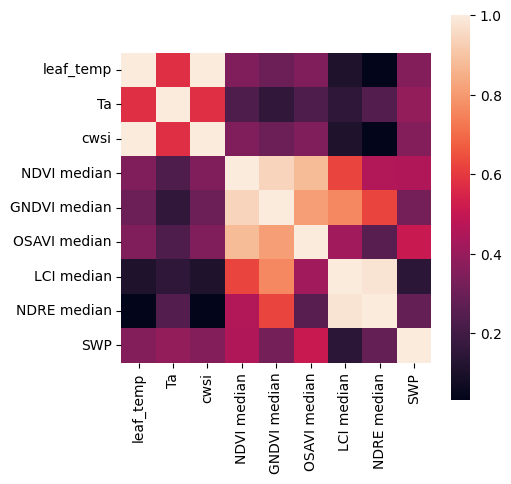

In [1005]:
f , ax = plt.subplots(figsize=(5,5))

sns.heatmap(abs(corrs),square=True,vmax=1)

<AxesSubplot:>

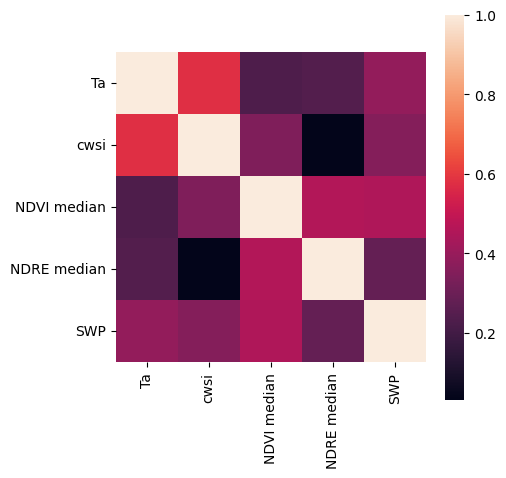

In [1006]:
mdf = mdf.drop(['LCI median','GNDVI median', 'leaf_temp','OSAVI median'], axis=1)
# mdf = mdf.drop(['leaf_temp'], axis=1)
corrs = mdf.corr()
f , ax = plt.subplots(figsize=(5,5))
sns.heatmap(abs(corrs),square=True,vmax=1)

In [1007]:
main['SWPc'].unique()

array(['WL-2', 'WL-3', 'WL-1'], dtype=object)

In [1008]:
correct_label= np.array(['WL-1', 'WL-2', 'WL-3'], dtype=object)
correct_label


array(['WL-1', 'WL-2', 'WL-3'], dtype=object)

In [1009]:
label_quality = LabelEncoder()
main['SWPc'] = label_quality.fit_transform(main['SWPc'])
main['SWPc'].isnull().sum()

0

In [1010]:
bins = (2,8,20)
group_names = ['WL1','WL2']
main['SWPc2'] = pd.cut(main['SWP'], bins=bins , labels=group_names)
main['SWPc2'] = label_quality.fit_transform(main['SWPc2'])
main['SWPc2'].isnull().sum()

0

In [1011]:
main

,tree_idx,test_number,leaf_temp,Ta,cwsi,NDVI median,GNDVI median,OSAVI median,LCI median,NDRE median,SWP,SWPc,SWPc2
0,1,T1,28.0,36.33,0.137931,0.651247,0.579653,0.311467,0.224935,0.157902,6.7,1,0
1,2,T1,26.0,36.33,0.000000,0.727823,0.628124,0.339363,0.256596,0.174475,8.7,2,1
2,3,T1,26.7,36.33,0.048276,0.731136,0.633427,0.348855,0.272154,0.187457,6.0,0,0
3,4,T1,29.3,36.33,0.227586,0.705379,0.588299,0.368542,0.211414,0.142261,5.7,0,0
4,5,T1,29.0,36.33,0.206897,0.745715,0.642535,0.393172,0.275420,0.187919,5.2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,14,T7,32.3,39.09,0.434483,0.651964,0.578798,0.306616,0.242141,0.172492,13.2,2,1
122,15,T7,36.4,39.09,0.717241,0.613730,0.552401,0.294611,0.227958,0.164832,11.3,2,1
123,16,T7,33.7,39.09,0.531034,0.675721,0.584211,0.332427,0.246689,0.173681,9.8,2,1
124,17,T7,33.9,39.09,0.544828,0.667222,0.585880,0.325666,0.247613,0.174950,8.5,1,1


SWPc 
 2    43
0    42
1    41
Name: SWPc, dtype: int64


<AxesSubplot:xlabel='SWPc', ylabel='count'>

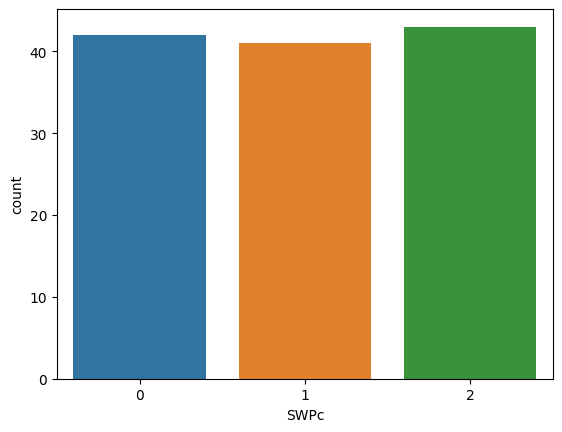

In [1012]:
print('SWPc \n',main['SWPc'].value_counts())
sns.countplot(x=main['SWPc'])


 SWPc2 
 0    70
1    56
Name: SWPc2, dtype: int64


<AxesSubplot:xlabel='SWPc2', ylabel='count'>

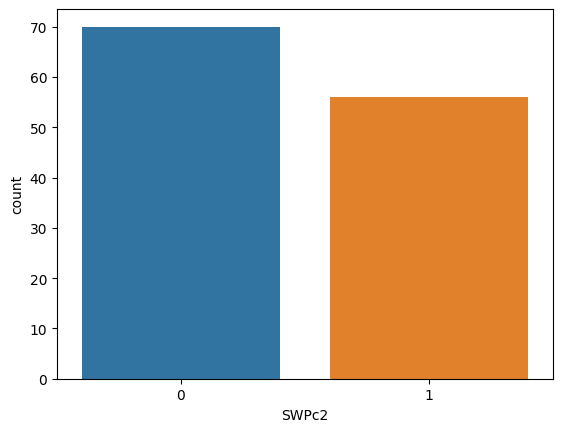

In [1013]:
print('\n SWPc2 \n',main['SWPc2'].value_counts())
sns.countplot(x=main['SWPc2'])

In [1014]:
X = mdf.drop('SWP',axis=1)
y = main['SWPc2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, \
                                                    random_state = 10)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)
cv=10

In [1015]:
rfc = RandomForestClassifier(n_estimators=250)
rfc.fit(X_train, y_train)
pred_rfc = rfc.predict(X_test)
print('Random Forest accuracy: ',accuracy_score(y_test, pred_rfc))
print(classification_report(y_test, pred_rfc))
print(confusion_matrix(y_test, pred_rfc))

Random Forest accuracy:  0.7368421052631579
              precision    recall  f1-score   support

           0       0.67      0.82      0.74        17
           1       0.82      0.67      0.74        21

    accuracy                           0.74        38
   macro avg       0.75      0.75      0.74        38
weighted avg       0.75      0.74      0.74        38

[[14  3]
 [ 7 14]]


In [1016]:
clf=SVC()
clf.fit(X_train,y_train)
pred_clf = clf.predict(X_test)
print('SVM accuracy: ',accuracy_score(y_test, pred_clf))
print(classification_report(y_test, pred_clf))
print(confusion_matrix(y_test, pred_clf))

SVM accuracy:  0.7631578947368421
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        17
           1       1.00      0.57      0.73        21

    accuracy                           0.76        38
   macro avg       0.83      0.79      0.76        38
weighted avg       0.85      0.76      0.76        38

[[17  0]
 [ 9 12]]


In [1017]:
gnb= GaussianNB()
gnb.fit(X_train,y_train)
pred_gnb = gnb.predict(X_test)
print('DT accuracy: ',accuracy_score(y_test, pred_gnb))
print(classification_report(y_test, pred_gnb))
print(confusion_matrix(y_test, pred_gnb))

DT accuracy:  0.7368421052631579
              precision    recall  f1-score   support

           0       0.64      0.94      0.76        17
           1       0.92      0.57      0.71        21

    accuracy                           0.74        38
   macro avg       0.78      0.76      0.73        38
weighted avg       0.80      0.74      0.73        38

[[16  1]
 [ 9 12]]


In [1018]:
dt= tree.DecisionTreeClassifier()
dt.fit(X_train,y_train)
pred_dt = dt.predict(X_test)
print('DT accuracy: ',accuracy_score(y_test, pred_dt))
print(classification_report(y_test, pred_dt))
print(confusion_matrix(y_test, pred_dt))

DT accuracy:  0.631578947368421
              precision    recall  f1-score   support

           0       0.57      0.76      0.65        17
           1       0.73      0.52      0.61        21

    accuracy                           0.63        38
   macro avg       0.65      0.64      0.63        38
weighted avg       0.66      0.63      0.63        38

[[13  4]
 [10 11]]


In [1019]:
knn= KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)
pred_knn = knn.predict(X_test)
print('KNN accuracy: ',accuracy_score(y_test, pred_knn))
print(classification_report(y_test, pred_knn))
print(confusion_matrix(y_test, pred_knn))

KNN accuracy:  0.7368421052631579
              precision    recall  f1-score   support

           0       0.67      0.82      0.74        17
           1       0.82      0.67      0.74        21

    accuracy                           0.74        38
   macro avg       0.75      0.75      0.74        38
weighted avg       0.75      0.74      0.74        38

[[14  3]
 [ 7 14]]


In [1032]:
mlpc= MLPClassifier(hidden_layer_sizes=(15,10,15),max_iter=2000)
mlpc.fit(X_train,y_train)
pred_mlpc = mlpc.predict(X_test)
print('Neural Network accuracy: ',accuracy_score(y_test, pred_mlpc))
print(classification_report(y_test, pred_mlpc))
print(confusion_matrix(y_test, pred_mlpc))

Neural Network accuracy:  0.7631578947368421
              precision    recall  f1-score   support

           0       0.67      0.94      0.78        17
           1       0.93      0.62      0.74        21

    accuracy                           0.76        38
   macro avg       0.80      0.78      0.76        38
weighted avg       0.81      0.76      0.76        38

[[16  1]
 [ 8 13]]


In [1033]:
cval_rf = np.array(cross_val_score(rfc, X, y, cv=cv))
cval_svc = np.array(cross_val_score(clf, X, y, cv=cv))
cval_gnb = np.array(cross_val_score(gnb, X, y, cv=cv))
cval_dt = np.array(cross_val_score(dt, X, y, cv=cv))
cval_knn = np.array(cross_val_score(knn, X, y, cv=cv))
cval_nn = np.array(cross_val_score(mlpc, X, y, cv=cv))

In [1034]:

# print('\n',cval_rf,'\n \n',cval_rf.mean(),cval_rf.max(),cval_rf.std())
# print('\n',cval_svc,'\n \n',cval_svc.mean(),cval_svc.max(),cval_svc.std())
# print('\n',cval_knn,'\n \n',cval_knn.mean(),cval_knn.max(),cval_knn.std())
# print('\n',cval_nn,'\n \n',cval_nn.mean(),cval_nn.max(),cval_nn.std())

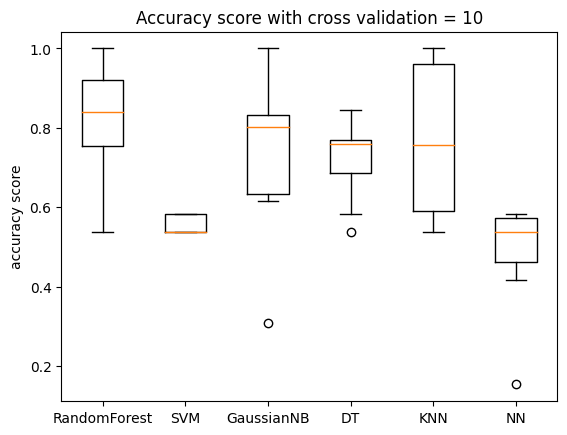

In [1035]:
data = [cval_rf,cval_svc,cval_gnb,cval_dt,cval_knn,cval_nn]
plt.boxplot(data)
plt.xticks([1, 2, 3, 4, 5, 6],['RandomForest','SVM','GaussianNB','DT','KNN','NN'])
plt.ylabel('accuracy score')
plt.title('Accuracy score with cross validation = ' + str(cv))
plt.show()

Optimized Hyperparameters
